In [3]:
# Setup - Install project in development mode
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python path: {sys.path[:3]}")

Project root: d:\UNI\DSP391m\project
Python path: ['d:\\UNI\\DSP391m\\project', 'c:\\Users\\fxlqt\\.conda\\envs\\dsp\\python310.zip', 'c:\\Users\\fxlqt\\.conda\\envs\\dsp\\DLLs']


# Traffic Forecast ML Training Pipeline

This notebook provides an end-to-end machine learning pipeline for traffic speed prediction.

## Pipeline Steps:
1. **Data Loading** - Load collected traffic data
2. **Exploratory Data Analysis** - Understand data distribution
3. **Feature Engineering** - Create temporal, spatial, weather features
4. **Data Preprocessing** - Clean, scale, split data
5. **Model Training** - Train multiple ML models
6. **Model Evaluation** - Compare performance metrics
7. **Feature Importance** - Identify key predictors
8. **Model Persistence** - Save best model

## 1. Setup and Imports

In [6]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML Pipeline imports - Skip DL for now due to import issues
from traffic_forecast.ml.data_loader import DataLoader
from traffic_forecast.ml.preprocess import DataPreprocessor, split_data, prepare_features_target
from traffic_forecast.ml.features import build_features
from traffic_forecast.ml.trainer import ModelTrainer

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(" All imports successful!")

 All imports successful!


## 2. Data Loading

In [7]:
# Initialize data loader
loader = DataLoader()

# Check available runs
print("Available data runs:")
runs = loader.list_runs()
for i, run in enumerate(runs):
    print(f"  [{i}] {run['name']} - {run['timestamp']}")

# Get data summary
summary = loader.get_data_summary()
print("\nData Summary:")
print(f"  Total runs: {summary['total_runs']}")
if 'latest_run' in summary:
    print(f"  Latest run: {summary['latest_run']['name']}")
    print(f"  Records: {summary['latest_run']['records']}")
    print(f"  Features: {len(summary['latest_run']['features'])}")

Available data runs:
  [0] download_20251027_185415 - 2025-10-27 18:54:15
  [1] download_20251027_181522 - 2025-10-27 18:15:22
  [2] download_20251026_210927 - 2025-10-26 21:09:27

Data Summary:
  Total runs: 3
  Latest run: download_20251027_185415
  Records: 120
  Features: 15


In [8]:
# Load data (choose one):

# Option 1: Load latest run only
df = loader.load_merged_data(run_idx=0)

# Option 2: Load all runs
# df = loader.load_multiple_runs()

print(f"Loaded {len(df)} records")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData shape: {df.shape}")
df.head()

Loaded 120 records

Columns: ['node_a_id', 'node_b_id', 'distance_km', 'duration_sec', 'speed_kmh', 'timestamp', 'api_type', 'lat', 'lon', 'temperature_c', 'precipitation_mm', 'wind_speed_kmh', 'node_id_node', 'lat_node', 'lon_node']

Data shape: (120, 15)


,node_a_id,node_b_id,distance_km,duration_sec,speed_kmh,timestamp,api_type,lat,lon,temperature_c,precipitation_mm,wind_speed_kmh,node_id_node,lat_node,lon_node
0,node-10.771233-106.693127,node-10.770127-106.694102,0.162720,15.959485,36.704960,2025-10-26 13:55:56.835383,mock,10.771233,106.693127,26.6,0.4,3.5,node-10.771233-106.693127,10.771233,106.693127
1,node-10.771233-106.693127,node-10.770167-106.694198,0.166630,17.665174,33.957746,2025-10-26 13:55:56.835401,mock,10.771233,106.693127,26.6,0.4,3.5,node-10.771233-106.693127,10.771233,106.693127
2,node-10.771233-106.693127,node-10.769198-106.694628,0.279404,28.154492,35.726235,2025-10-26 13:55:56.835407,mock,10.771233,106.693127,26.6,0.4,3.5,node-10.771233-106.693127,10.771233,106.693127
3,node-10.764404-106.698972,node-10.763832-106.698113,0.113406,13.423668,30.413435,2025-10-26 13:55:56.835413,mock,10.764404,106.698972,26.6,0.4,3.5,node-10.764404-106.698972,10.764404,106.698972
4,node-10.764404-106.698972,node-10.765088-106.699763,0.115051,16.382343,25.282229,2025-10-26 13:55:56.835417,mock,10.764404,106.698972,26.6,0.4,3.5,node-10.764404-106.698972,10.764404,106.698972


## 3. Exploratory Data Analysis

In [9]:
# Basic statistics
print("Dataset Statistics:")
print(df.describe())

# Missing values
print("\nMissing Values:")
missing = df.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(missing)
else:
    print("No missing values!")

Dataset Statistics:
       distance_km  duration_sec   speed_kmh                      timestamp  \
count   120.000000    120.000000  120.000000                            120   
mean      0.130536     16.814912   31.147999  2025-10-26 13:55:56.836555776   
min       0.008255      0.720053   16.497521     2025-10-26 13:55:56.835383   
25%       0.016828      2.211230   24.689021  2025-10-26 13:55:56.836082176   
50%       0.076129      7.699476   30.262330  2025-10-26 13:55:56.836566272   
75%       0.146721     18.090292   38.364163  2025-10-26 13:55:56.836986880   
max       0.654357    116.801574   44.992913     2025-10-26 13:55:56.837680   
std       0.159376     23.245186    8.236060                            NaN   

              lat         lon  temperature_c  precipitation_mm  \
count  120.000000  120.000000   1.200000e+02      1.200000e+02   
mean    10.770089  106.698928   2.660000e+01      4.000000e-01   
min     10.763673  106.690539   2.660000e+01      4.000000e-01   
25% 

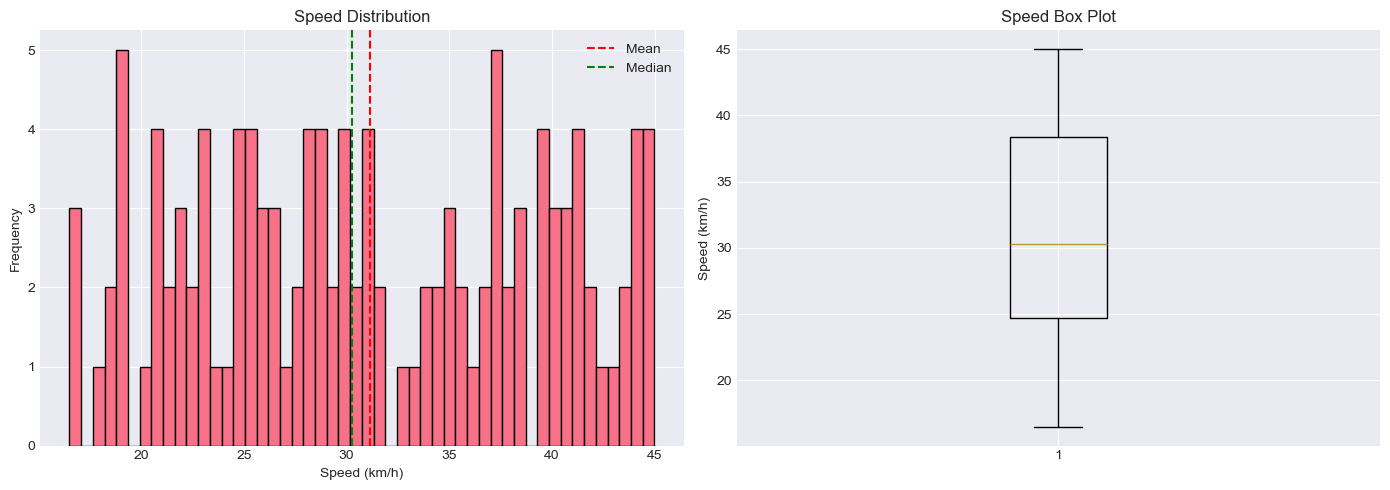

Speed Statistics:
  Mean: 31.15 km/h
  Median: 30.26 km/h
  Std: 8.24 km/h
  Min: 16.50 km/h
  Max: 44.99 km/h


In [10]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['speed_kmh'], bins=50, edgecolor='black')
axes[0].set_title('Speed Distribution')
axes[0].set_xlabel('Speed (km/h)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['speed_kmh'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(df['speed_kmh'].median(), color='green', linestyle='--', label='Median')
axes[0].legend()

# Box plot
axes[1].boxplot(df['speed_kmh'])
axes[1].set_title('Speed Box Plot')
axes[1].set_ylabel('Speed (km/h)')

plt.tight_layout()
plt.show()

print(f"Speed Statistics:")
print(f"  Mean: {df['speed_kmh'].mean():.2f} km/h")
print(f"  Median: {df['speed_kmh'].median():.2f} km/h")
print(f"  Std: {df['speed_kmh'].std():.2f} km/h")
print(f"  Min: {df['speed_kmh'].min():.2f} km/h")
print(f"  Max: {df['speed_kmh'].max():.2f} km/h")

In [ ]:
# Weather vs Speed
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature
axes[0].scatter(df['temperature_c'], df['speed_kmh'], alpha=0.5)
axes[0].set_title('Temperature vs Speed')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Speed (km/h)')

# Precipitation
axes[1].scatter(df['precipitation_mm'], df['speed_kmh'], alpha=0.5)
axes[1].set_title('Precipitation vs Speed')
axes[1].set_xlabel('Precipitation (mm)')
axes[1].set_ylabel('Speed (km/h)')

# Wind
axes[2].scatter(df['wind_speed_kmh'], df['speed_kmh'], alpha=0.5)
axes[2].set_title('Wind vs Speed')
axes[2].set_xlabel('Wind Speed (km/h)')
axes[2].set_ylabel('Speed (km/h)')

plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [11]:
# Build all features
print("Building features...")
df_features = build_features(
    df,
    include_temporal=True,
    include_spatial=True,
    include_weather=True,
    include_traffic=True,
    include_lags=False,  # Set True if you have time series data
    include_rolling=False  # Set True for rolling window features
)

print(f"\nFeatures created: {df_features.shape[1]} columns")
print(f"New feature columns:")
new_cols = set(df_features.columns) - set(df.columns)
print(f"  {sorted(new_cols)}")

Building features...

Features created: 37 columns
New feature columns:
  ['day_cos', 'day_of_month', 'day_of_week', 'day_sin', 'hour', 'hour_cos', 'hour_sin', 'is_congested', 'is_raining', 'is_rush_hour', 'is_weekend', 'lat_diff', 'lon_diff', 'month', 'precipitation_category', 'speed_category', 'speed_to_distance_ratio', 'temp_category', 'time_of_day', 'weather_severity', 'wind_category', 'year']


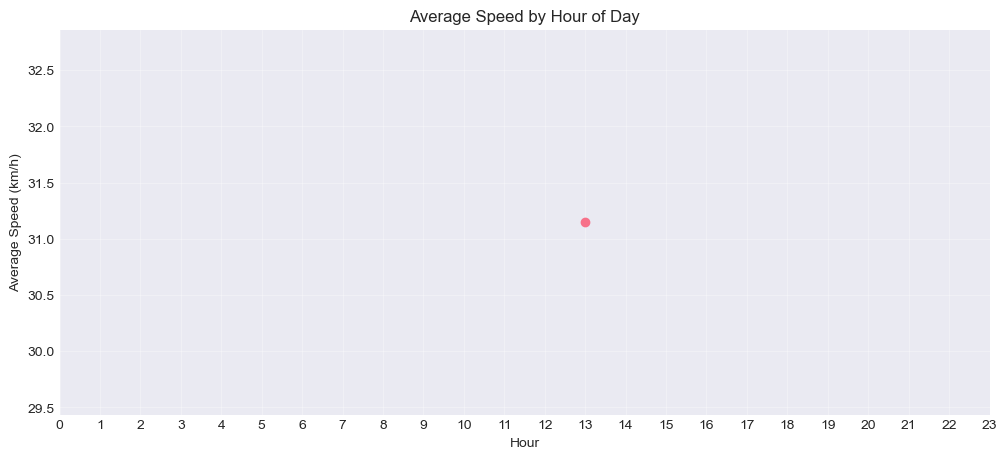

In [12]:
# Visualize temporal patterns
if 'hour' in df_features.columns:
    hourly_speed = df_features.groupby('hour')['speed_kmh'].mean()
    
    plt.figure(figsize=(12, 5))
    plt.plot(hourly_speed.index, hourly_speed.values, marker='o')
    plt.title('Average Speed by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Average Speed (km/h)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(24))
    plt.show()

## 5. Data Preprocessing & Splitting

In [13]:
# Split data into train, validation, and test sets
train_df, val_df, test_df = split_data(
    df_features,
    target_column='speed_kmh',
    test_size=0.2,
    val_size=0.1,
    random_state=42,
    time_based=False  # Set True for time-series split
)

print(f"Data split:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val:   {len(val_df)} samples")
print(f"  Test:  {len(test_df)} samples")

Data split:
  Train: 84 samples
  Val:   12 samples
  Test:  24 samples


In [14]:
# Prepare features and target
X_train, y_train = prepare_features_target(train_df, target_column='speed_kmh')
X_val, y_val = prepare_features_target(val_df, target_column='speed_kmh')
X_test, y_test = prepare_features_target(test_df, target_column='speed_kmh')

print(f"\nFeature matrix shape:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

print(f"\nFeatures used: {list(X_train.columns)}")


Feature matrix shape:
  X_train: (84, 31)
  X_val:   (12, 31)
  X_test:  (24, 31)

Features used: ['distance_km', 'duration_sec', 'lat', 'lon', 'temperature_c', 'precipitation_mm', 'wind_speed_kmh', 'lat_node', 'lon_node', 'hour', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'is_rush_hour', 'time_of_day', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lat_diff', 'lon_diff', 'is_raining', 'precipitation_category', 'temp_category', 'wind_category', 'weather_severity', 'speed_category', 'is_congested', 'speed_to_distance_ratio']


In [16]:
# Preprocess data (scaling, imputation)
preprocessor = DataPreprocessor(
    target_column='speed_kmh',
    scaler_type='standard',  # 'standard', 'robust', or 'none'
    handle_outliers=True
)

# Fit on training data
preprocessor.fit(train_df, feature_columns=list(X_train.columns))

# Transform all sets
train_processed = preprocessor.transform(train_df)
val_processed = preprocessor.transform(val_df)
test_processed = preprocessor.transform(test_df)

# Extract preprocessed features
X_train_scaled, _ = prepare_features_target(train_processed, target_column='speed_kmh')
X_val_scaled, _ = prepare_features_target(val_processed, target_column='speed_kmh')
X_test_scaled, _ = prepare_features_target(test_processed, target_column='speed_kmh')

print(" Data preprocessing complete!")

 Data preprocessing complete!


## 6. Model Training

### 6.1 Train Single Model

In [17]:
# Train Random Forest model
trainer = ModelTrainer(
    model_type='random_forest',
    params={
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'random_state': 42,
        'n_jobs': -1
    }
)

# Train
trainer.train(X_train_scaled, y_train, X_val_scaled, y_val)

# Evaluate on test set
test_metrics = trainer.evaluate(X_test_scaled, y_test)

Training random_forest model...

Train Metrics:
  RMSE: 2.1047
  MAE:  1.6735
  R²:   0.9330
  MAPE: 0.0525

Validation Metrics:
  RMSE: 3.9783
  MAE:  3.6181
  R²:   0.8325
  MAPE: 0.1166
Training complete. Train R²: 0.9330
Validation R²: 0.8325

Test Metrics:
  RMSE: 2.6636
  MAE:  2.2945
  R²:   0.8682
  MAPE: 0.0797

Test Metrics:
  RMSE: 2.6636
  MAE:  2.2945
  R²:   0.8682
  MAPE: 0.0797


### 6.2 Compare Multiple Models

In [20]:
# Train multiple models and compare
models_to_train = ['xgboost', 'lightgbm', 'gradient_boosting']
results = []

for model_type in models_to_train:
    print(f"\n{'='*60}")
    print(f"Training {model_type.upper()}")
    print(f"{'='*60}")
    
    trainer = ModelTrainer(model_type=model_type)
    trainer.train(X_train_scaled, y_train, X_val_scaled, y_val)
    
    # Evaluate on train, val, test sets
    train_metrics = trainer.evaluate(X_train_scaled, y_train)
    val_metrics = trainer.evaluate(X_val_scaled, y_val)
    test_metrics = trainer.evaluate(X_test_scaled, y_test)
    
    results.append({
        'Model': model_type,
        'Train_R2': train_metrics['r2'],
        'Val_R2': val_metrics['r2'],
        'Test_RMSE': test_metrics['rmse'],
        'Test_MAE': test_metrics['mae'],
        'Test_R2': test_metrics['r2'],
        'Test_MAPE': test_metrics['mape']
    })

# Create comparison dataframe
comparison_df = pd.DataFrame(results)
print(f"\n{'='*60}")
print("MODEL COMPARISON")
print(f"{'='*60}")
print(comparison_df.to_string(index=False))


Training XGBOOST
Training xgboost model...

Train Metrics:
  RMSE: 0.1107
  MAE:  0.0784
  R²:   0.9998
  MAPE: 0.0024

Validation Metrics:
  RMSE: 3.8507
  MAE:  3.1046
  R²:   0.8431
  MAPE: 0.0929
Training complete. Train R²: 0.9998
Validation R²: 0.8431

Test Metrics:
  RMSE: 0.1107
  MAE:  0.0784
  R²:   0.9998
  MAPE: 0.0024

Test Metrics:
  RMSE: 3.8507
  MAE:  3.1046
  R²:   0.8431
  MAPE: 0.0929

Test Metrics:
  RMSE: 2.4241
  MAE:  1.9338
  R²:   0.8908
  MAPE: 0.0673

Training LIGHTGBM
Training lightgbm model...

Train Metrics:
  RMSE: 3.5976
  MAE:  2.9897
  R²:   0.8041
  MAPE: 0.1039

Validation Metrics:
  RMSE: 4.2130
  MAE:  3.3996
  R²:   0.8122
  MAPE: 0.1004
Training complete. Train R²: 0.8041
Validation R²: 0.8122

Test Metrics:
  RMSE: 3.5976
  MAE:  2.9897
  R²:   0.8041
  MAPE: 0.1039

Test Metrics:
  RMSE: 4.2130
  MAE:  3.3996
  R²:   0.8122
  MAPE: 0.1004

Test Metrics:
  RMSE: 2.9172
  MAE:  2.3282
  R²:   0.8419
  MAPE: 0.0804

Training GRADIENT_BOOSTING
Tr

### 6.3 Cross-Validation

In [ ]:
# Perform 5-fold cross-validation
cv_results = trainer.cross_validate(
    X_train_scaled,
    y_train,
    cv=5,
    scoring='r2'
)

print(f"\nCross-validation scores: {cv_results['scores']}")
print(f"Mean CV score: {cv_results['mean_score']:.4f} (+/- {cv_results['std_score']:.4f})")

## 7. Model Evaluation

In [ ]:
# Make predictions
y_pred = trainer.predict(X_test_scaled)

# Prediction vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title('Predicted vs Actual Speed')
axes[0].set_xlabel('Actual Speed (km/h)')
axes[0].set_ylabel('Predicted Speed (km/h)')
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_title('Residuals Plot')
axes[1].set_xlabel('Predicted Speed (km/h)')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (km/h)')
plt.ylabel('Frequency')
plt.show()

## 8. Feature Importance

In [ ]:
# Get feature importance
importance_df = trainer.get_feature_importance(top_n=20)

if not importance_df.empty:
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))
else:
    print("Feature importance not available for this model type.")

## 9. Hyperparameter Tuning (Optional)

In [ ]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Tune hyperparameters
tuning_trainer = ModelTrainer(model_type='random_forest')
tuning_results = tuning_trainer.tune_hyperparameters(
    X_train_scaled,
    y_train,
    param_grid=param_grid,
    cv=3,
    scoring='r2'
)

print(f"\nBest parameters: {tuning_results['best_params']}")
print(f"Best CV score: {tuning_results['best_score']:.4f}")

## 10. Save Model

In [ ]:
# Save the best model
model_path = trainer.save_model(name='best_traffic_model.joblib')

print(f"\n Model saved to: {model_path}")
print(f"\nModel performance summary:")
print(f"  Training R²: {trainer.training_metrics['r2']:.4f}")
if trainer.validation_metrics:
    print(f"  Validation R²: {trainer.validation_metrics['r2']:.4f}")
print(f"  Test R²: {trainer.test_metrics['r2']:.4f}")
print(f"  Test RMSE: {trainer.test_metrics['rmse']:.4f}")
print(f"  Test MAE: {trainer.test_metrics['mae']:.4f}")

## 11. Load and Use Saved Model

In [ ]:
# Load saved model
loaded_trainer = ModelTrainer.load_model(model_path)

# Make predictions with loaded model
y_pred_loaded = loaded_trainer.predict(X_test_scaled)

# Verify predictions match
assert np.allclose(y_pred, y_pred_loaded), "Predictions don't match!"
print(" Model loaded successfully and predictions verified!")

## Summary

This notebook demonstrated:
-  Loading traffic data from collected runs
-  Exploratory data analysis
-  Feature engineering (temporal, spatial, weather)
-  Data preprocessing and splitting
-  Training multiple ML models
-  Model evaluation and comparison
-  Feature importance analysis
-  Hyperparameter tuning
-  Model persistence and loading

### Next Steps:
1. Collect more data for better model performance
2. Try advanced models (neural networks, ensemble methods)
3. Implement real-time prediction API
4. Deploy model to production
5. Monitor model performance over time

## 12. Deep Learning Models (LSTM) 

For time-series forecasting, LSTM models can capture temporal dependencies better than traditional ML models.

In [ ]:
# Check if deep learning is available
from traffic_forecast.ml import HAS_DL

if HAS_DL:
    from traffic_forecast.ml import DLModelTrainer
    print(" Deep Learning models available")
    print(f"  Available models: {list(DLModelTrainer.MODELS.keys())}")
else:
    print(" Deep Learning not available")
    print("  Install TensorFlow: pip install tensorflow")

### 12.1 Train LSTM Model

LSTM (Long Short-Term Memory) is designed for sequential data and can learn long-term dependencies.

In [ ]:
if HAS_DL:
    # Create LSTM trainer
    lstm_trainer = DLModelTrainer(
        model_type='lstm',
        params={
            'sequence_length': 12,  # Use last 12 timesteps
            'lstm_units': [128, 64],
            'dropout_rate': 0.2,
            'learning_rate': 0.001
        }
    )
    
    print("Training LSTM model...")
    print(f"Training samples: {len(X_train_scaled)}")
    print(f"This may take a few minutes...")
    
    # Train (fewer epochs for demo)
    lstm_trainer.train(
        X_train_scaled, y_train,
        X_val_scaled, y_val,
        epochs=30,
        batch_size=32,
        verbose=1
    )
    
    print("\n LSTM training complete!")
else:
    print(" Skipping LSTM training - TensorFlow not available")

### 12.2 Evaluate LSTM Model

In [ ]:
if HAS_DL and 'lstm_trainer' in locals():
    # Evaluate on test set
    lstm_metrics = lstm_trainer.evaluate(X_test_scaled, y_test)
    
    print("LSTM Test Metrics:")
    print(f"  RMSE: {lstm_metrics['rmse']:.4f}")
    print(f"  MAE:  {lstm_metrics['mae']:.4f}")
    print(f"  R²:   {lstm_metrics['r2']:.4f}")
    print(f"  MAPE: {lstm_metrics['mape']:.2f}%")
    
    # Compare with best traditional ML model
    print(f"\nComparison with XGBoost:")
    print(f"  XGBoost R²: {xgb_metrics['r2']:.4f}")
    print(f"  LSTM R²:    {lstm_metrics['r2']:.4f}")
    
    if lstm_metrics['r2'] > xgb_metrics['r2']:
        print("  → LSTM performs better! ")
    else:
        print("  → XGBoost still better (more data may help LSTM)")
else:
    print(" LSTM not trained")

### 12.3 Save LSTM Model

In [ ]:
if HAS_DL and 'lstm_trainer' in locals():
    # Save LSTM model
    lstm_path = lstm_trainer.save_model('traffic_lstm_v1')
    print(f" LSTM model saved to {lstm_path}")
    
    # Model can be loaded later with:
    # loaded_lstm = DLModelTrainer.load_model(lstm_path, model_type='lstm')
else:
    print(" LSTM not trained, nothing to save")

## 13. Model Selection Guidance 

### When to use each model:

| Model | Best For | Speed | Accuracy | Data Needed |
|-------|----------|-------|----------|-------------|
| **Ridge/Lasso** | Baseline, interpretability |  |  | Small |
| **Random Forest** | General purpose, robust |  |  | Medium |
| **XGBoost** | Best accuracy (tabular) |  |  | Medium |
| **LightGBM** | Speed + accuracy |  |  | Medium |
| **LSTM** | Time series, sequences |  |  | Large |
| **ASTGCN** | Graph + time series |  |  | Large + Graph |

### Recommendations:
- **For production**: Use XGBoost or LightGBM (best balance)
- **For research**: Try LSTM with more data
- **For real-time**: Use LightGBM (fastest)
- **For baseline**: Start with Ridge/Random Forest